In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

import warnings
warnings.filterwarnings('ignore')

## 1. Загрузка данных

С помощью данного датасета будем решать задачу бинарной классификации. Определять является гриб ядовитым (к ним же отнесены и несъедобные/нежелательные для употребления в пищу грибы) или съедобным

**Целевая перменная** - класс гриба (e - съедобный, p - ядовитый)

Главная задача определить, что гриб несъедобный, чтобы человек его не съел и не отравился

Несъедобный гриб - positive
Съедобный гриб - negative

Здача максимизировать recall, чтобы модель, как можно реже называла несъедобный гриб съедобным.

In [6]:
df = pd.read_csv('/kaggle/input/mushroom-classification/mushrooms.csv')
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [4]:
df.shape

(8124, 23)

In [5]:
print('Все колонки: ', df.columns.tolist())
df.info()

Все колонки:  ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing      

Всего 22 признака, каждый из которых является категориальным

### Гипотеза 1

Дерево решений покажет более высокий recall в определении ядовитого гриба по сравнению с логистической регрессией с one-hot кодированием, потому что все признаки категориальные

## 2. EDA

In [8]:
df.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

### Распределение классов

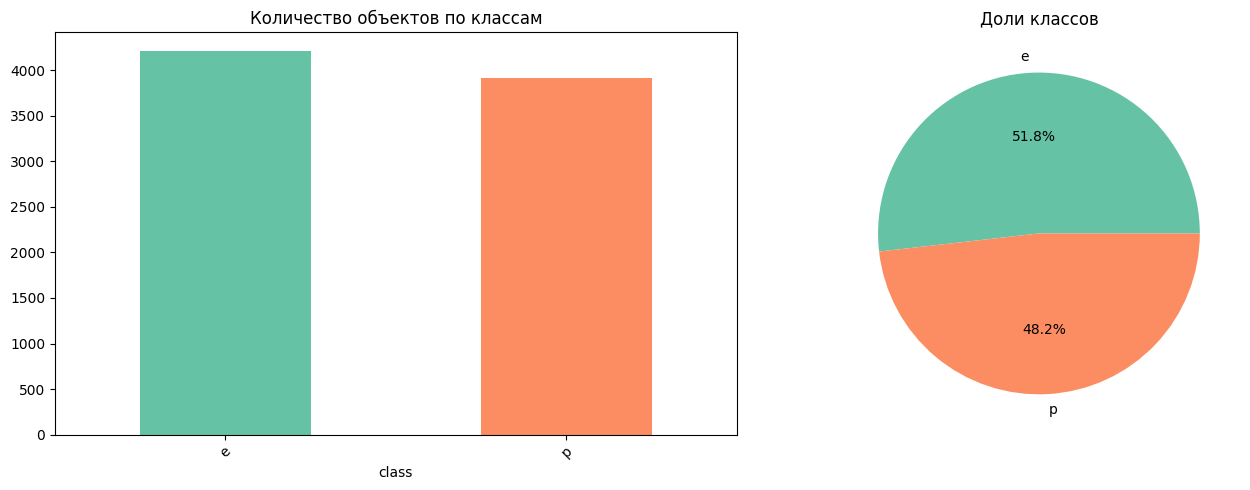

In [9]:
target_col = 'class'
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df[target_col].value_counts().plot.bar(ax=axes[0], color=sns.color_palette('Set2'))
axes[0].set_title('Количество объектов по классам')
axes[0].tick_params(axis='x', rotation=45)

df[target_col].value_counts(normalize=True).plot.pie(ax=axes[1], autopct='%1.1f%%', colors=sns.color_palette('Set2'))
axes[1].set_ylabel('')
axes[1].set_title('Доли классов')
plt.tight_layout()
plt.show()

Классы сбалансированы

In [13]:
for col in df.columns:
    print(col, df[col].nunique(), df[col].unique())

class 2 ['p' 'e']
cap-shape 6 ['x' 'b' 's' 'f' 'k' 'c']
cap-surface 4 ['s' 'y' 'f' 'g']
cap-color 10 ['n' 'y' 'w' 'g' 'e' 'p' 'b' 'u' 'c' 'r']
bruises 2 ['t' 'f']
odor 9 ['p' 'a' 'l' 'n' 'f' 'c' 'y' 's' 'm']
gill-attachment 2 ['f' 'a']
gill-spacing 2 ['c' 'w']
gill-size 2 ['n' 'b']
gill-color 12 ['k' 'n' 'g' 'p' 'w' 'h' 'u' 'e' 'b' 'r' 'y' 'o']
stalk-shape 2 ['e' 't']
stalk-root 5 ['e' 'c' 'b' 'r' '?']
stalk-surface-above-ring 4 ['s' 'f' 'k' 'y']
stalk-surface-below-ring 4 ['s' 'f' 'y' 'k']
stalk-color-above-ring 9 ['w' 'g' 'p' 'n' 'b' 'e' 'o' 'c' 'y']
stalk-color-below-ring 9 ['w' 'p' 'g' 'b' 'n' 'e' 'y' 'o' 'c']
veil-type 1 ['p']
veil-color 4 ['w' 'n' 'o' 'y']
ring-number 3 ['o' 't' 'n']
ring-type 5 ['p' 'e' 'l' 'f' 'n']
spore-print-color 9 ['k' 'n' 'u' 'h' 'w' 'r' 'o' 'y' 'b']
population 6 ['s' 'n' 'a' 'v' 'y' 'c']
habitat 7 ['u' 'g' 'm' 'd' 'p' 'w' 'l']


veil-type (тип вуали) в датасете всегда 'p', хотя в описании заявлено, что он может быть и 'u'. Но этот тип не представден. Его можно удалить, так как константный признак пользы при обучении модели не несет

в stalk-root есть тип '?'. Это не пропуск значения, согласно описанию датасета.

In [14]:
df = df.drop('veil-type', axis = 1)

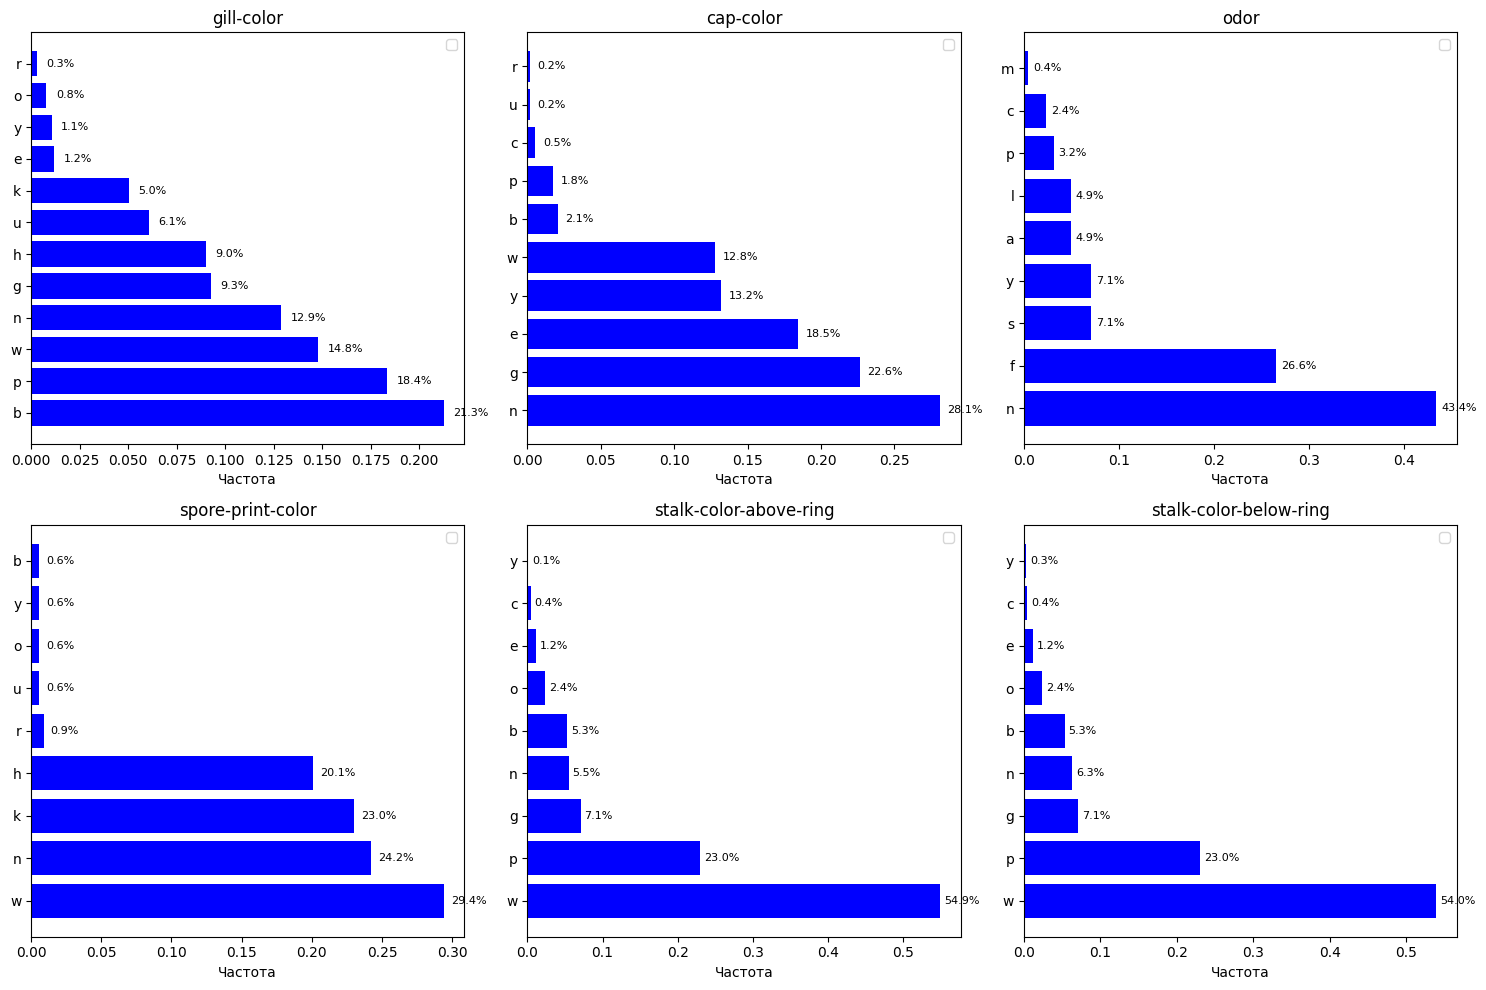

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

problematic_cols = ['gill-color', 'cap-color', 'odor', 'spore-print-color', 'stalk-color-above-ring', 'stalk-color-below-ring']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, col in enumerate(problematic_cols):
    freqs = df[col].value_counts(normalize=True).sort_values(ascending=False)
    
    axes[idx].barh(range(len(freqs)), freqs.values, color='blue')
    axes[idx].set_yticks(range(len(freqs)))
    axes[idx].set_yticklabels(freqs.index)
    axes[idx].set_xlabel('Частота')
    axes[idx].set_title(col)
    for i, (val, freq) in enumerate(freqs.items()):
        axes[idx].text(freq + 0.005, i, f'{freq:.1%}', va='center', fontsize=8)
    
    axes[idx].legend()

plt.tight_layout()
plt.show()